In [83]:
# Import required libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from keras.optimizers import Adam

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

import yfinance as yf

In [40]:
def oneHotEncode(df, columns):
    all_years = [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
    all_months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    all_days = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
    all_days_of_week = [1, 2, 3, 4, 5, 6, 7]

    one_hot_encoded_df = pd.get_dummies(df, columns = columns)
    one_hot_encoded_df = one_hot_encoded_df.reindex(columns=[f'year_{year}' for year in all_years], fill_value=0)
    one_hot_encoded_df = one_hot_encoded_df.reindex(columns=[f'month_{month}' for month in all_months], fill_value=0)
    one_hot_encoded_df = one_hot_encoded_df.reindex(columns=[f'day_{day}' for day in all_days], fill_value=0)
    one_hot_encoded_df = one_hot_encoded_df.reindex(columns=[f'day_of_week_{day_of_week}' for day_of_week in all_days_of_week], fill_value=0)

    print(one_hot_encoded_df.head())
    print(df.head())

    new_dataframe = pd.concat([df, one_hot_encoded_df], axis=1)

    return new_dataframe

In [41]:
# List of all stocks
stocks = ['aapl', 'amzn', 'googl', 'msft', 'tsla']

# Get rid of annoying errors that don't matter
pd.set_option('mode.chained_assignment', None)

# Create the scaler
sentimentScaler = MinMaxScaler()
stockScaler = MinMaxScaler()

# Create the datasets from the csvs
# Could use a lot of work to reduce loc but it doesn't matter for marks
def dataFrames(stock):

    # Create dataframes for the tweets and prices 
    tweet_df = pd.read_csv('csv/' + stock + '.csv')
    tweet_1_df = pd.read_csv('csv/' + stock + '_1.csv')
    price_df = pd.read_csv('csv/' + stock + '_price.csv')

    # Rename the date column so they match between dataframes
    tweet_df.rename(columns = {'DATE': 'date'}, inplace = True)
    tweet_1_df.rename(columns = {'Date': 'date'}, inplace = True)
    price_df.rename(columns = {'Date' : 'date', 'Close/Last': 'stockPrice'}, inplace = True)

    # Rename the score column so they match between dataframes
    tweet_df.rename(columns = {'TEXTBLOB_POLARITY': 'sentimentScore'}, inplace = True)
    tweet_1_df.rename(columns = {'score': 'sentimentScore'}, inplace = True)

    # Remove the $ sign in stock price, and convert columns to float64 (may be redundant)
    price_df['stockPrice'] = price_df['stockPrice'].str.replace('$', '')
    tweet_df['sentimentScore'] = pd.to_numeric(tweet_df['sentimentScore'])
    tweet_1_df['sentimentScore'] = pd.to_numeric(tweet_1_df['sentimentScore'])
    price_df['stockPrice'] = pd.to_numeric(price_df['stockPrice'])

    # Convert the dates to pd datetime
    price_df['date'] = pd.to_datetime(price_df['date'])
    tweet_df['date'] = pd.to_datetime(tweet_df['date'], dayfirst = True)
    tweet_1_df['date'] = pd.to_datetime(tweet_1_df['date'])

    # Reduce to only nessicary columns
    tweet_df = tweet_df[['date', 'sentimentScore']]
    tweet_1_df = tweet_1_df[['date', 'sentimentScore']]
    price_df = price_df[['date', 'stockPrice']]

    # Merge the dataframes based on the date column
    merged_1_df = pd.merge(tweet_df, price_df, on = 'date')
    merged_2_df = pd.merge(tweet_1_df, price_df, on = 'date')
    merged_df = pd.merge(merged_1_df, merged_2_df, how = 'outer')

    # Drop all duplicates
    final_df = merged_df.drop_duplicates()

    # Convert date to specific variables
    final_df['year'] = final_df['date'].dt.year
    final_df['month'] = final_df['date'].dt.month
    final_df['day'] = final_df['date'].dt.day
    final_df['day_of_week'] = final_df['date'].dt.dayofweek

    # One-hot encoding, should be done for all for financial data
    #final_df = oneHotEncode(final_df, ['year', 'month', 'day', 'day_of_week'])
    #final_df = pd.get_dummies(final_df, columns = ['year', 'month', 'day', 'day_of_week'])

    # Drop the original date column
    final_df = final_df.drop(columns = ['date'])

    # Save to csv for double checking
    #final_df.to_csv('final_' + stock + '.csv', index = False)

    # Scale the numerical values
    final_df[['sentimentScore']] = sentimentScaler.fit_transform(final_df[['sentimentScore']])
    final_df[['stockPrice']] = stockScaler.fit_transform(final_df[['stockPrice']])

    # Split into X and y
    X = final_df.drop(columns = ['stockPrice'])
    y = final_df['stockPrice']

    # Split the datasets into training and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

    '''# Reshape the datasets
    X_train_reshaped = reshape_data(X_train)
    X_test_reshaped = reshape_data(X_test)'''

    # NOTE: Sequence length (1) could be improved by making one of the commented functions above work.
    X_train_reshaped = np.reshape(X_train, (-1, 1, X_train.shape[1]))
    X_test_reshaped = np.reshape(X_test, (-1,  1, X_test.shape[1]))
    y_train_array = y_train.values
    y_test_array = y_test.values

    # Return the training and test datasets
    return X_train_reshaped, X_test_reshaped, y_train_array, y_test_array

In [42]:
all_data = {}  # Dictionary to hold data for all stocks

for stock in stocks:
    # Run the 'dataFrames' function for each stock
    data = dataFrames(stock)
    
    # Store the datasets in the dictionary
    all_data[stock] = {
        'X_train': data[0],
        'X_test': data[1],
        'y_train': data[2],
        'y_test': data[3]
    }

    # Print the shapes of X_train and y_train for the current stock
    print(f"{stock} X_train shape: {data[0].shape}")
    print(f"{stock} y_train shape: {data[2].shape}")

aapl X_train shape: (21542, 1, 5)
aapl y_train shape: (21542,)
amzn X_train shape: (19976, 1, 5)
amzn y_train shape: (19976,)
googl X_train shape: (16819, 1, 5)
googl y_train shape: (16819,)
msft X_train shape: (14943, 1, 5)
msft y_train shape: (14943,)
tsla X_train shape: (20452, 1, 5)
tsla y_train shape: (20452,)


In [43]:
# Initialize dictionary to store the models for each stock
models = {}

for stock, datasets in all_data.items():
    X_train = datasets['X_train']
    y_train = datasets['y_train']
    X_test = datasets['X_test']
    y_test = datasets['y_test']
    
    # Define the model for current stock
    model = Sequential([
        Input(shape=X_train.shape[1:]),
        LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1:], 1)),
        Dropout(0.2), 
        LSTM(units=50, return_sequences=True),
        Dropout(0.2),
        LSTM(units=50),
        Dropout(0.2),
        Dense(units=1)
    ])

    # Convert data type of input arrays to float32
    X_train = X_train.astype('float32')
    y_train = y_train.astype('float32')
    X_test = X_test.astype('float32')
    y_test = y_test.astype('float32')

    # Compile model using the Adam optimizer
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    # Ensure that X_train and y_train have the same number of samples (if necessary)
    X_train = X_train[:len(y_train)]

    # Fit the model with verbose settings for debugging
    model.fit(X_train, y_train, epochs=1, batch_size=32, verbose=0)

    # Evaluate the model and print the loss
    loss = model.evaluate(X_test, y_test)
    print(f"{stock} Test Loss: ", loss)

    # Store the model in the dictionary
    models[stock] = model

169/169 [==============================] - 1s 4ms/step - loss: 0.0489
aapl Test Loss:  0.04890572279691696
157/157 [==============================] - 1s 4ms/step - loss: 0.0973
amzn Test Loss:  0.09730158746242523
132/132 [==============================] - 1s 4ms/step - loss: 0.0657
googl Test Loss:  0.06572912633419037
117/117 [==============================] - 1s 4ms/step - loss: 0.0738
msft Test Loss:  0.0737779513001442
160/160 [==============================] - 1s 3ms/step - loss: 0.0376
tsla Test Loss:  0.03758905455470085


In [44]:
for stock, datasets in all_data.items():
    X_train = datasets['X_train']
    y_train = datasets['y_train']
    X_test = datasets['X_test']
    y_test = datasets['y_test']

    # Flatten X data for compatibility with RandomForest, Linear Regression, and Decision Tree
    num_samples, timesteps, num_features = X_train.shape
    X_train_2d = X_train.reshape(num_samples, timesteps * num_features)
    X_test_2d = X_test.reshape(X_test.shape[0], timesteps * num_features)

    # Store processed data
    all_data[stock] = (X_train_2d, X_test_2d, y_train, y_test)

# Initialize dictionaries for models and their performances
rf_models = {}
rf_losses = {}
lr_models = {}
lr_losses = {}
dt_models = {}
dt_losses = {}

for stock, (X_train_2d, X_test_2d, y_train, y_test) in all_data.items():
    # RandomForestRegressor
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train_2d, y_train)
    rf_predictions = rf_model.predict(X_test_2d)
    rf_loss = mean_squared_error(y_test, rf_predictions)
    rf_models[stock] = rf_model
    rf_losses[stock] = rf_loss
    print(f"{stock} Random Forest Test Loss: ", rf_loss)

    # Linear Regression
    lr_model = LinearRegression()
    lr_model.fit(X_train_2d, y_train)
    lr_predictions = lr_model.predict(X_test_2d)
    lr_loss = mean_squared_error(y_test, lr_predictions)
    lr_models[stock] = lr_model
    lr_losses[stock] = lr_loss
    print(f"{stock} Linear Regression Test Loss: ", lr_loss)
    
    # Decision Tree Regressor
    dt_model = DecisionTreeRegressor(random_state=42)
    dt_model.fit(X_train_2d, y_train)
    dt_predictions = dt_model.predict(X_test_2d)
    dt_loss = mean_squared_error(y_test, dt_predictions)
    dt_models[stock] = dt_model
    dt_losses[stock] = dt_loss
    print(f"{stock} Decision Tree Test Loss: ", dt_loss)

aapl Random Forest Test Loss:  4.1968745959621414e-10
aapl Linear Regression Test Loss:  0.011016191169306345
aapl Decision Tree Test Loss:  1.9007839717704197e-32
amzn Random Forest Test Loss:  1.1315437327411813e-09
amzn Linear Regression Test Loss:  0.010219437240305293
amzn Decision Tree Test Loss:  3.912598012761351e-32
googl Random Forest Test Loss:  5.083253809348119e-09
googl Linear Regression Test Loss:  0.006389820932366614
googl Decision Tree Test Loss:  3.846647740672896e-32
msft Random Forest Test Loss:  1.955834244360713e-09
msft Linear Regression Test Loss:  0.00498345298212116
msft Decision Tree Test Loss:  7.520586315893814e-33
tsla Random Forest Test Loss:  8.65813642465698e-09
tsla Linear Regression Test Loss:  0.02937480932458805
tsla Decision Tree Test Loss:  1.2126277193947334e-32


In [45]:
# Initialize dictionaries for GaussianNB models and their accuracies
gaussian_nb_models = {}
gaussian_nb_accuracies = {}

# Label encoder to convert continuous labels to discrete integers
label_encoder = LabelEncoder()

for stock, (X_train_2d, X_test_2d, y_train, y_test) in all_data.items():
    # Convert continuous labels to discrete integers
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    # Define and initialize the Gaussian Naive Bayes model
    bayes_model = GaussianNB()

    # Fit the model with the reshaped 2D training data and encoded labels
    bayes_model.fit(X_train_2d, y_train_encoded)

    # Make predictions on the reshaped 2D test data
    bayes_predictions = bayes_model.predict(X_test_2d)

    # Calculate and print the accuracy for the test set predictions
    accuracy = accuracy_score(y_test_encoded, bayes_predictions)
    print(f"{stock} Gaussian Naive Bayes Test Accuracy: ", accuracy)

    # Store the model and its accuracy
    gaussian_nb_models[stock] = bayes_model
    gaussian_nb_accuracies[stock] = accuracy

aapl Gaussian Naive Bayes Test Accuracy:  0.9658373561084292
amzn Gaussian Naive Bayes Test Accuracy:  0.9983983983983984
googl Gaussian Naive Bayes Test Accuracy:  0.9938168846611177
msft Gaussian Naive Bayes Test Accuracy:  0.9352248394004282
tsla Gaussian Naive Bayes Test Accuracy:  0.9822022296107961


In [100]:
predictions = {}
true_price = {}
final_tweets = {}
symbols = ['AAPL', 'AMZN', 'GOOGL', 'MSFT', 'TSLA']

def predictData(symbol, stock = 'aapl'):

    # Get the model for the stock
    current_price_data = [[168.45], [168.45], [168.45], [168.45], [168.45], [168.45], [168.45], [168.45], [168.45], [168.45]]
    current_price_data = pd.DataFrame(current_price_data, columns=['stockPrice'])
    current_price_data['stockPrice'] = pd.to_numeric(current_price_data['stockPrice'])
    current_price_data['stockPrice'] = stockScaler.transform(current_price_data[['stockPrice']])
    
    # Get the true price
    y_true = current_price_data.values
    y_true = stockScaler.inverse_transform(y_true)
    print(y_true.shape)

    # Get the current tweets
    current_tweets = pd.read_csv('csv/output.csv')
    current_tweets.rename(columns = {'Date': 'date'}, inplace = True)
    current_tweets.rename(columns = {'Sentiment': 'sentimentScore'}, inplace = True)
    
    # Remove the $ sign in stock price, and convert columns to float64 (may be redundant)
    sentiment_mapping = {'Negative': -1, 'Neutral': 0, 'Positive': 1}
    current_tweets['sentimentScore'] = current_tweets['sentimentScore'].map(sentiment_mapping)
    current_tweets = current_tweets[['date', 'sentimentScore']]
    current_tweets['sentimentScore'] = pd.to_numeric(current_tweets['sentimentScore'])
    current_tweets['sentimentScore'] = sentimentScaler.transform(current_tweets[['sentimentScore']])

    # Convert the dates to pd datetime
    current_tweets['date'] = pd.to_datetime(current_tweets['date'])
    current_tweets['year'] = current_tweets['date'].dt.year
    current_tweets['month'] = current_tweets['date'].dt.month
    current_tweets['day'] = current_tweets['date'].dt.day
    current_tweets['day_of_week'] = current_tweets['date'].dt.dayofweek

    # Final changes
    X = current_tweets.drop(columns = ['date'])
    X = np.reshape(X, (-1, 1, X.shape[1]))
    X = X.astype('float32')

    # Use old data
    '''X = all_data['aapl'][1]
    X = np.reshape(X, (-1, 1, X.shape[1]))
    print(X.shape)'''

    y_test = stockScaler.inverse_transform(model.predict(X))
    print(y_test.shape)
    predictions[stock] = y_test
    true_price[stock] = y_true
    final_tweets[stock] = X

# Predict for each stock
'''for stock in stocks:
    print(f"Predictions for {stock}:")
    predictData(stock)'''

predictData('AAPL')

print(predictions['aapl'])

(10, 1)
1/1 [==============================] - 0s 16ms/step
(10, 1)
[[18.379349]
 [18.379349]
 [18.379349]
 [18.379349]
 [18.379349]
 [18.379349]
 [18.379349]
 [18.379349]
 [18.379349]
 [18.379349]]


In [102]:
def plotPredictions(y_true, y_pred, X): 

    X_df = X.reshape(-1, X.shape[-1])
    X_df = pd.DataFrame(X_df, columns = ['sentimentScore', 'year', 'month', 'day', 'day_of_week'])
    print(X_df)

    X['date'] = X['year'].astype(str) + '-' + X['month'].astype(str) + '-' + X['day'].astype(str)
    X['date'] = pd.to_datetime(y_pred_merged['date'])

    X.drop(columns = ['year', 'month', 'day', 'day_of_week', 'sentimentScore'], inplace = True)

    y_pred_merged = pd.merge(X, y_pred, left_index=True, right_index=True)
    y_true_merged = pd.merge(X, y_true, left_index=True, right_index=True)

    plt.figure(figsize=(12, 6))
    plt.plot(y_pred_merged, y_pred_merged['stockPrice'], label = 'Predicted Price', color = 'red')
    plt.plot(y_true_merged, y_true_merged['stockPrice'], label = 'True Price', color = 'blue')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.title('Predicted vs True Stock Price')
    plt.legend
    plt.xticks(rotation = 45)
    plt.tight_layout()
    plt.show()

plotPredictions(true_price['aapl'], predictions['aapl'], final_tweets['aapl'])

   sentimentScore    year  month  day  day_of_week
0        0.678082  2024.0    4.0  8.0          0.0
1        0.609589  2024.0    4.0  8.0          0.0
2        0.746575  2024.0    4.0  8.0          0.0
3        0.609589  2024.0    4.0  8.0          0.0
4        0.678082  2024.0    4.0  8.0          0.0
5        0.609589  2024.0    4.0  8.0          0.0
6        0.678082  2024.0    4.0  8.0          0.0
7        0.746575  2024.0    4.0  8.0          0.0
8        0.678082  2024.0    4.0  8.0          0.0
9        0.746575  2024.0    4.0  8.0          0.0


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

Metrics for aapl:
MSE: 101.68148798978098
MAE: 10.083723914793632


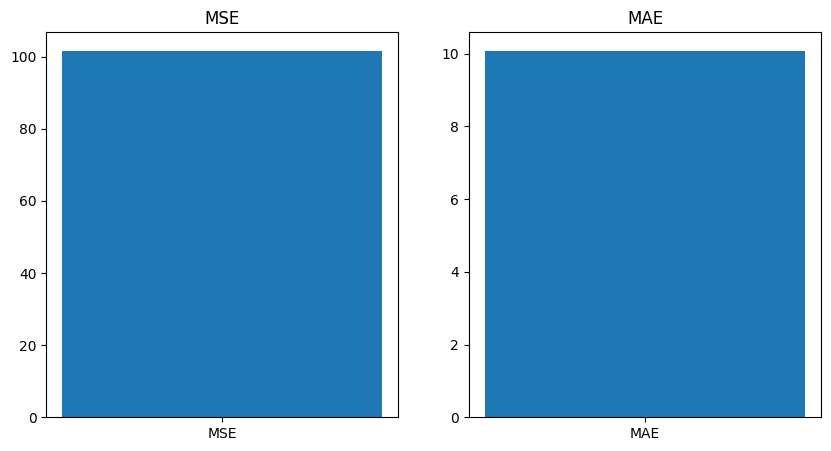

In [80]:
def calculate_and_plot_metrics(y_true, y_pred):
    # Calculate metrics
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)

    # Print metrics
    print(f"MSE: {mse}")
    print(f"MAE: {mae}")

    # Plot metrics
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title("MSE")
    plt.bar(['MSE'], [mse])

    plt.subplot(1, 2, 2)
    plt.title("MAE")
    plt.bar(['MAE'], [mae])

    plt.show()

# Calculate and plot metrics for each stock
'''for stock in stocks:
    print(f"Metrics for {stock}:")
    y_true = true_price[stock]
    y_pred = predictions[stock]
    calculate_and_plot_metrics(y_true, y_pred)'''

print(f"Metrics for aapl:")
y_true = true_price['aapl']
y_pred = predictions['aapl']
calculate_and_plot_metrics(y_true, y_pred)

In [89]:
# Assuming y_true, X_test are defined, and model is trained

# Predict scores
y_scores = y_pred

# Find the optimal threshold
print(y_scores)
fpr, tpr, thresholds = roc_curve(y_true.astype(int), y_scores)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Convert the predicted values to binary based on the optimal threshold
y_pred_binary_optimal = np.where(y_scores > optimal_threshold, 1, 0)

# Calculate metrics using the binary values with the optimal threshold
accuracy_opt = accuracy_score(y_true.astype(int), y_pred_binary_optimal)
precision_opt = precision_score(y_true.astype(int), y_pred_binary_optimal)
recall_opt = recall_score(y_true.astype(int), y_pred_binary_optimal)
f1_opt = f1_score(y_true.astype(int), y_pred_binary_optimal)
roc_auc_opt = roc_auc_score(y_true.astype(int), y_scores)

# Print metrics
print(f"Optimal Threshold: {optimal_threshold}")
print(f"Precision: {precision_opt}")
print(f"Recall: {recall_opt}")
print(f"F1 Score: {f1_opt}")
print(f"ROC AUC: {roc_auc_opt}")

# Plot metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
values_opt = [accuracy_opt, precision_opt, recall_opt, f1_opt, roc_auc_opt]

plt.figure(figsize=(10, 5))
plt.bar(metrics, values_opt, color='skyblue')
plt.ylim([0.0, 1.0])
plt.title('Performance Metrics with Optimized Threshold')
plt.show()


[[18.379349]
 [18.379349]
 [18.379349]
 [18.379349]
 [18.379349]
 [18.379349]
 [18.379349]
 [18.379349]
 [18.379349]
 [18.379349]]


ValueError: y_true takes value in {8} and pos_label is not specified: either make y_true take value in {0, 1} or {-1, 1} or pass pos_label explicitly.